# Installations

In [5]:
!pip install dask

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 33.1 MB/s eta 0:00:00


# Data transformation

In [108]:
vcf_full_dir = '/home/skomlev/data/vcf/full'
test_out_dir = '/home/skomlev/data/test_out'

full_dv_vcf_file = 'NA24385_cutadapt_bwa_MarkDuplicates_DeepVariant_Precise_filtered.gz'
full_dv_gvcf_file = 'NA24385.cutadapt.bwa.MarkDuplicates.DeepVariant.g.vcf.gz'

na12878_file_gz = 'NA12878_cutadapt_bwa_MarkDuplicates_DeepVariant_filtered_genotypes.gz'
pt12878_file_gz = 'NA12878.filtered_genotypes.vcf.gz'

full_dv_vcf_path = vcf_full_dir + '/' + full_dv_vcf_file
full_dv_gvcf_path = vcf_full_dir + '/gvcf/' + full_dv_gvcf_file

na12878_path = vcf_full_dir + '/' + na12878_file_gz
pt12878_path = vcf_full_dir + '/' + pt12878_file_gz

full_dv_tsv_path = test_out_dir + '/dv_full.tsv'
full_dv_gtsv_path = test_out_dir + '/dv_full.g.tsv'

na12878_tsv_path = test_out_dir + '/na12878.tsv'
pt12878_tsv_path = test_out_dir + '/pt12878.tsv'

## VCF to DataFrame

### VCF to TSV

In [2]:
import re

In [3]:
def vcf_to_tsv(vcf_path: str, tsv_path: str):
    with open(vcf_path) as file:
        vcf = file.read()
        tsv_start = re.search('#CHROM', vcf).span()[0]
        tsv_str = vcf[tsv_start + 1:]
    
    with open(tsv_path, 'w') as file:
        file.write(tsv_str)

In [113]:
#!gzip -d -k $pt12878_path

In [5]:
vcf_to_tsv(vcf_path=full_dv_vcf_path.rstrip('.gz'), tsv_path=full_dv_tsv_path)

In [77]:
vcf_to_tsv(vcf_path=na12878_path.rstrip('.gz'), tsv_path=na12878_tsv_path)

In [111]:
vcf_to_tsv(vcf_path=pt12878_path.rstrip('.gz'), tsv_path=pt12878_tsv_path)

In [78]:
!head $na12878_tsv_path

CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA12878
chr1	10236	.	AACCCT	A	7.6	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:5:7:4,3:0.428571:5,5,0
chr1	10492	.	C	T	3.7	PASS	.	GT:GQ:DP:AD:VAF:PL	0/1:4:8:6,2:0.25:1,0,16
chr1	14248	.	T	G	11.9	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:8:3:0,3:1:11,10,0
chr1	14354	.	C	A	3.5	PASS	.	GT:GQ:DP:AD:VAF:PL	0/1:3:3:1,2:0.666667:0,0,7
chr1	14907	.	A	G	16.5	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:14:8:0,8:1:16,16,0
chr1	14930	.	A	G	14.6	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:12:7:0,7:1:14,14,0
chr1	15118	.	A	G	11.4	PASS	.	GT:GQ:DP:AD:VAF:PL	0/1:3:12:4,8:0.666667:8,0,0
chr1	15211	.	T	G	27.1	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:21:8:0,8:1:27,22,0
chr1	15274	.	A	T	17.9	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:13:5:0,5:1:17,13,0


### TSV to DataFrame

In [79]:
vcf_col_names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

In [80]:
import pandas as pd
import dask.dataframe as dd

In [81]:
def vcf_tsv_to_df(tsv_path: str, rename_cols=True, drop_info=True, drop_filter = True) -> pd.DataFrame:
    vcf_df = pd.read_csv(tsv_path, sep='\t')
    
    if rename_cols:
        vcf_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
    
    if drop_info:
        vcf_df = vcf_df.drop('INFO', axis = 1)
    if drop_filter:
        vcf_df = vcf_df.drop('FILTER', axis = 1)
        
    vcf_df['ID'] = vcf_df.index
    return vcf_df

In [10]:
dvf = vcf_tsv_to_df(full_dv_tsv_path)
dvf

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE
0,chr1,10352,0,T,TA,4.0,GT:GQ:DP:AD:VAF:PL,"1/1:3:6:3,2:0.333333:0,5,0"
1,chr1,10389,1,AC,A,7.2,GT:GQ:DP:AD:VAF:PL,"1/1:3:7:4,2:0.285714:4,2,0"
2,chr1,13613,2,T,A,13.3,GT:GQ:DP:AD:VAF:PL,"1/1:10:5:0,5:1:12,13,0"
3,chr1,13684,3,C,T,13.8,GT:GQ:DP:AD:VAF:PL,"1/1:11:3:0,3:1:13,13,0"
4,chr1,13813,4,T,G,11.6,GT:GQ:DP:AD:VAF:PL,"1/1:9:5:0,5:1:11,12,0"
...,...,...,...,...,...,...,...,...
4584820,chr22,50807889,4584820,C,G,25.1,GT:GQ:DP:AD:VAF:PL,"1/1:25:10:0,9:0.9:25,40,0"
4584821,chr22,50807905,4584821,T,A,4.2,GT:GQ:DP:AD:VAF:PL,"1/1:4:9:2,7:0.777778:2,14,0"
4584822,chr22,50807909,4584822,G,T,4.6,GT:GQ:DP:AD:VAF:PL,"1/1:4:10:3,7:0.7:2,16,0"
4584823,chr22,50807933,4584823,G,T,5.5,GT:GQ:DP:AD:VAF:PL,"0/1:5:13:10,3:0.230769:3,0,11"


In [151]:
na128 = vcf_tsv_to_df(na12878_tsv_path)
na128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE
0,chr1,10236,0,AACCCT,A,7.6,GT:GQ:DP:AD:VAF:PL,"1/1:5:7:4,3:0.428571:5,5,0"
1,chr1,10492,1,C,T,3.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:6,2:0.25:1,0,16"
2,chr1,14248,2,T,G,11.9,GT:GQ:DP:AD:VAF:PL,"1/1:8:3:0,3:1:11,10,0"
3,chr1,14354,3,C,A,3.5,GT:GQ:DP:AD:VAF:PL,"0/1:3:3:1,2:0.666667:0,0,7"
4,chr1,14907,4,A,G,16.5,GT:GQ:DP:AD:VAF:PL,"1/1:14:8:0,8:1:16,16,0"
...,...,...,...,...,...,...,...,...
4623036,chrX,156028976,4623036,GCCCCCGCACC,G,10.3,GT:GQ:DP:AD:VAF:PL,"0/1:10:29:15,14:0.482759:9,0,20"
4623037,chrX,156029656,4623037,TA,T,35.7,GT:GQ:DP:AD:VAF:PL,"1/1:17:8:1,7:0.875:35,17,0"
4623038,chrX,156029906,4623038,T,G,19.4,GT:GQ:DP:AD:VAF:PL,"0/1:15:10:6,4:0.4:19,0,16"
4623039,chrX,156029912,4623039,T,G,17.6,GT:GQ:DP:AD:VAF:PL,"0/1:14:8:5,3:0.375:17,0,15"


In [114]:
pt128 = vcf_tsv_to_df(pt12878_tsv_path)
pt128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE
0,chr1,727477,0,G,A,0,GT,1|1
1,chr1,727717,1,G,C,0,GT,1|1
2,chr1,740738,2,C,T,0,GT,1|0
3,chr1,744224,3,C,A,0,GT,1|1
4,chr1,766566,4,A,G,0,GT,1|1
...,...,...,...,...,...,...,...,...
4192703,chrX,155556641,4192703,G,C,0,GT,1|1
4192704,chrX,155556706,4192704,G,A,0,GT,1|1
4192705,chrX,155557041,4192705,C,T,0,GT,1|1
4192706,chrX,155557395,4192706,C,T,0,GT,1|1


### Feature extraction

In [149]:
def extract_vcf_features(vcf_df: pd.DataFrame) -> pd.DataFrame:
    vcf_df[['GT','GQ','DP','AD','VAF','PL']] = vcf_df['SAMPLE'].str.split(':',expand=True)
    vcf_df[['PL_0/0','PL_0/1','PL_1/1']] = vcf_df['PL'].str.split(',',expand=True)
    vcf_df[['AD_ref','AD_alt']] = vcf_df['AD'].str.split(',',expand=True)
    vcf_df['CHROM_num'] = vcf_df['CHROM'].str.split('r',expand=True)[1]
    
    vcf_df['ref_alt_diff'] = abs(vcf_df['REF'].str.len() - vcf_df['ALT'].str.len())
    
    vcf_df.index = vcf_df['ID']
    vcf_df = vcf_df[['CHROM_num','POS','QUAL','GQ','DP','AD_ref','AD_alt','VAF','PL_0/0','PL_0/1','PL_1/1','ref_alt_diff']]

    vcf_dtypes = {'CHROM_num': 'int32',
              'GQ': 'int32','DP': 'int32','VAF': 'float64',
              'AD_ref': 'int32','AD_alt': 'int32',
              'PL_0/0': 'int32','PL_0/1': 'int32','PL_1/1': 'int32'}
    vcf_df = vcf_df.astype(vcf_dtypes)
    
    return vcf_df

In [14]:
dvf = extract_vcf_features(dvf)
dvf

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1
2,1,13613,13.3,10,5,0,5,1.000000,12,13,0,0
3,1,13684,13.8,11,3,0,3,1.000000,13,13,0,0
4,1,13813,11.6,9,5,0,5,1.000000,11,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4584820,22,50807889,25.1,25,10,0,9,0.900000,25,40,0,0
4584821,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0
4584822,22,50807909,4.6,4,10,3,7,0.700000,2,16,0,0
4584823,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0


In [88]:
na128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE,GT,GQ,...,AD,VAF,PL,PL_0/0,PL_0/1,PL_1/1,AD_ref,AD_alt,CHROM_num,ref_alt_diff
0,chr1,10236,0,AACCCT,A,7.6,GT:GQ:DP:AD:VAF:PL,"1/1:5:7:4,3:0.428571:5,5,0",1/1,5,...,"4,3",0.428571,"5,5,0",5,5,0,4,3,1,5
1,chr1,10492,1,C,T,3.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:6,2:0.25:1,0,16",0/1,4,...,"6,2",0.25,"1,0,16",1,0,16,6,2,1,0
2,chr1,14248,2,T,G,11.9,GT:GQ:DP:AD:VAF:PL,"1/1:8:3:0,3:1:11,10,0",1/1,8,...,"0,3",1,"11,10,0",11,10,0,0,3,1,0
3,chr1,14354,3,C,A,3.5,GT:GQ:DP:AD:VAF:PL,"0/1:3:3:1,2:0.666667:0,0,7",0/1,3,...,"1,2",0.666667,"0,0,7",0,0,7,1,2,1,0
4,chr1,14907,4,A,G,16.5,GT:GQ:DP:AD:VAF:PL,"1/1:14:8:0,8:1:16,16,0",1/1,14,...,"0,8",1,"16,16,0",16,16,0,0,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4623036,chrX,156028976,4623036,GCCCCCGCACC,G,10.3,GT:GQ:DP:AD:VAF:PL,"0/1:10:29:15,14:0.482759:9,0,20",0/1,10,...,"15,14",0.482759,"9,0,20",9,0,20,15,14,X,10
4623037,chrX,156029656,4623037,TA,T,35.7,GT:GQ:DP:AD:VAF:PL,"1/1:17:8:1,7:0.875:35,17,0",1/1,17,...,"1,7",0.875,"35,17,0",35,17,0,1,7,X,1
4623038,chrX,156029906,4623038,T,G,19.4,GT:GQ:DP:AD:VAF:PL,"0/1:15:10:6,4:0.4:19,0,16",0/1,15,...,"6,4",0.4,"19,0,16",19,0,16,6,4,X,0
4623039,chrX,156029912,4623039,T,G,17.6,GT:GQ:DP:AD:VAF:PL,"0/1:14:8:5,3:0.375:17,0,15",0/1,14,...,"5,3",0.375,"17,0,15",17,0,15,5,3,X,0


In [153]:
dv128 = na128[na128['CHROM'] != 'chrX']
dv128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE,GT,GQ,...,AD,VAF,PL,PL_0/0,PL_0/1,PL_1/1,AD_ref,AD_alt,CHROM_num,ref_alt_diff
ID,,,,,,,,,,,,,,,,,,,,,
0,chr1,10236,0,AACCCT,A,7.6,GT:GQ:DP:AD:VAF:PL,"1/1:5:7:4,3:0.428571:5,5,0",1/1,5,...,"4,3",0.428571,"5,5,0",5,5,0,4,3,1,5
1,chr1,10492,1,C,T,3.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:6,2:0.25:1,0,16",0/1,4,...,"6,2",0.25,"1,0,16",1,0,16,6,2,1,0
2,chr1,14248,2,T,G,11.9,GT:GQ:DP:AD:VAF:PL,"1/1:8:3:0,3:1:11,10,0",1/1,8,...,"0,3",1,"11,10,0",11,10,0,0,3,1,0
3,chr1,14354,3,C,A,3.5,GT:GQ:DP:AD:VAF:PL,"0/1:3:3:1,2:0.666667:0,0,7",0/1,3,...,"1,2",0.666667,"0,0,7",0,0,7,1,2,1,0
4,chr1,14907,4,A,G,16.5,GT:GQ:DP:AD:VAF:PL,"1/1:14:8:0,8:1:16,16,0",1/1,14,...,"0,8",1,"16,16,0",16,16,0,0,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470606,chr22,50807889,4470606,C,G,9.7,GT:GQ:DP:AD:VAF:PL,"1/1:8:6:0,6:1:9,13,0",1/1,8,...,"0,6",1,"9,13,0",9,13,0,0,6,22,0
4470607,chr22,50807906,4470607,A,G,5.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:4,4:0.5:3,0,7",0/1,4,...,"4,4",0.5,"3,0,7",3,0,7,4,4,22,0
4470608,chr22,50807909,4470608,G,T,8.3,GT:GQ:DP:AD:VAF:PL,"0/1:8:8:4,4:0.5:7,0,18",0/1,8,...,"4,4",0.5,"7,0,18",7,0,18,4,4,22,0


In [154]:
dv128 = extract_vcf_features(dv128)
dv128

/tmp/ipykernel_1102957/3191999610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf_df[['GT','GQ','DP','AD','VAF','PL']] = vcf_df['SAMPLE'].str.split(':',expand=True)
/tmp/ipykernel_1102957/3191999610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf_df[['PL_0/0','PL_0/1','PL_1/1']] = vcf_df['PL'].str.split(',',expand=True)
/tmp/ipykernel_1102957/3191999610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff
ID,,,,,,,,,,,,
0,1,10236,7.6,5,7,4,3,0.428571,5,5,0,5
1,1,10492,3.7,4,8,6,2,0.250000,1,0,16,0
2,1,14248,11.9,8,3,0,3,1.000000,11,10,0,0
3,1,14354,3.5,3,3,1,2,0.666667,0,0,7,0
4,1,14907,16.5,14,8,0,8,1.000000,16,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4470606,22,50807889,9.7,8,6,0,6,1.000000,9,13,0,0
4470607,22,50807906,5.7,4,8,4,4,0.500000,3,0,7,0
4470608,22,50807909,8.3,8,8,4,4,0.500000,7,0,18,0


In [155]:
na128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE,GT,GQ,...,AD,VAF,PL,PL_0/0,PL_0/1,PL_1/1,AD_ref,AD_alt,CHROM_num,ref_alt_diff
ID,,,,,,,,,,,,,,,,,,,,,
0,chr1,10236,0,AACCCT,A,7.6,GT:GQ:DP:AD:VAF:PL,"1/1:5:7:4,3:0.428571:5,5,0",1/1,5,...,"4,3",0.428571,"5,5,0",5,5,0,4,3,1,5
1,chr1,10492,1,C,T,3.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:6,2:0.25:1,0,16",0/1,4,...,"6,2",0.25,"1,0,16",1,0,16,6,2,1,0
2,chr1,14248,2,T,G,11.9,GT:GQ:DP:AD:VAF:PL,"1/1:8:3:0,3:1:11,10,0",1/1,8,...,"0,3",1,"11,10,0",11,10,0,0,3,1,0
3,chr1,14354,3,C,A,3.5,GT:GQ:DP:AD:VAF:PL,"0/1:3:3:1,2:0.666667:0,0,7",0/1,3,...,"1,2",0.666667,"0,0,7",0,0,7,1,2,1,0
4,chr1,14907,4,A,G,16.5,GT:GQ:DP:AD:VAF:PL,"1/1:14:8:0,8:1:16,16,0",1/1,14,...,"0,8",1,"16,16,0",16,16,0,0,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4623036,chrX,156028976,4623036,GCCCCCGCACC,G,10.3,GT:GQ:DP:AD:VAF:PL,"0/1:10:29:15,14:0.482759:9,0,20",0/1,10,...,"15,14",0.482759,"9,0,20",9,0,20,15,14,X,10
4623037,chrX,156029656,4623037,TA,T,35.7,GT:GQ:DP:AD:VAF:PL,"1/1:17:8:1,7:0.875:35,17,0",1/1,17,...,"1,7",0.875,"35,17,0",35,17,0,1,7,X,1
4623038,chrX,156029906,4623038,T,G,19.4,GT:GQ:DP:AD:VAF:PL,"0/1:15:10:6,4:0.4:19,0,16",0/1,15,...,"6,4",0.4,"19,0,16",19,0,16,6,4,X,0


In [92]:
dvf.to_csv('na128.csv')

# Prediction

In [15]:
from joblib import load
import pickle

## Random Forest

In [16]:
forest_path = '/home/skomlev/models/forest4.sav'

In [4]:
#!gzip -dk $model_path

In [5]:
forest4 = pickle.load(open(model_path, 'rb'))
forest4

RandomForestClassifier()

In [32]:
feature_names = list(dvf.columns)
feature_names

['CHROM_num',
 'POS',
 'QUAL',
 'GQ',
 'DP',
 'AD_ref',
 'AD_alt',
 'VAF',
 'PL_0/0',
 'PL_0/1',
 'PL_1/1',
 'ref_alt_diff']

In [8]:
import time
import numpy as np

start_time = time.time()
importances = forest4.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest4.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 1.253 seconds


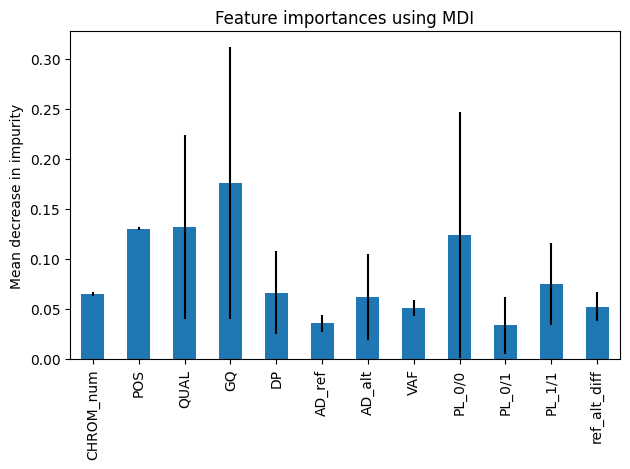

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [39]:
preds4 = forest4.predict(dvf)

In [40]:
preds4

array([False, False, False, ..., False, False, False])

In [41]:
dvf['preds4'] = preds4
dvf

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,preds4
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1,False
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1,False
2,1,13613,13.3,10,5,0,5,1.000000,12,13,0,0,False
3,1,13684,13.8,11,3,0,3,1.000000,13,13,0,0,False
4,1,13813,11.6,9,5,0,5,1.000000,11,12,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584820,22,50807889,25.1,25,10,0,9,0.900000,25,40,0,0,False
4584821,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0,False
4584822,22,50807909,4.6,4,10,3,7,0.700000,2,16,0,0,False
4584823,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0,False


In [ ]:
dvf[dvf['preds4'] == True]

## Gradient Boosting

In [17]:
xgb4_path = '/home/skomlev/models/xgb_4.sav'

In [19]:
xgb4 = pickle.load(open(xgb4_path, 'rb'))
xgb4

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [22]:
preds_xgb4 = xgb4.predict(dvf)
preds_xgb4

array([0, 0, 0, ..., 0, 0, 0])

In [159]:
preds_dv128 = xgb4.predict(dv128)
preds_dv128

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
dvf['preds_xgb4'] = preds_xgb4
dvf

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,preds_xgb4
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1,0
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1,0
2,1,13613,13.3,10,5,0,5,1.000000,12,13,0,0,0
3,1,13684,13.8,11,3,0,3,1.000000,13,13,0,0,0
4,1,13813,11.6,9,5,0,5,1.000000,11,12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584820,22,50807889,25.1,25,10,0,9,0.900000,25,40,0,0,0
4584821,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0,0
4584822,22,50807909,4.6,4,10,3,7,0.700000,2,16,0,0,0
4584823,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0,0


In [160]:
dv128['preds_xgb4'] = preds_dv128
dv128

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,preds_xgb4
ID,,,,,,,,,,,,,
0,1,10236,7.6,5,7,4,3,0.428571,5,5,0,5,0
1,1,10492,3.7,4,8,6,2,0.250000,1,0,16,0,0
2,1,14248,11.9,8,3,0,3,1.000000,11,10,0,0,0
3,1,14354,3.5,3,3,1,2,0.666667,0,0,7,0,0
4,1,14907,16.5,14,8,0,8,1.000000,16,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470606,22,50807889,9.7,8,6,0,6,1.000000,9,13,0,0,0
4470607,22,50807906,5.7,4,8,4,4,0.500000,3,0,7,0,0
4470608,22,50807909,8.3,8,8,4,4,0.500000,7,0,18,0,0


In [132]:
na128.index = na128
na128

/tmp/ipykernel_1102957/1705488703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na128['dummy'] = 22


,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid,dummy
248,1,263722,34.2,34,33,21,12,0.363636,34,0,47,0,True,22
332,1,630211,33.0,33,32,21,11,0.343750,32,0,53,0,True,22
335,1,631859,55.7,45,27,0,27,1.000000,55,45,0,1,True,22
336,1,632834,25.5,25,41,29,12,0.292683,25,0,52,0,True,22
338,1,634332,30.8,31,27,15,12,0.444444,30,0,46,0,True,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470567,22,50785209,31.6,31,18,10,8,0.444444,31,0,41,0,True,22
4470571,22,50788602,43.1,30,12,0,12,1.000000,43,30,0,0,True,22
4470573,22,50789463,31.6,31,22,10,12,0.545455,31,0,42,0,True,22
4470574,22,50789509,42.4,35,19,0,18,0.947368,42,35,0,0,True,22


In [28]:
dvf['is_valid'] = True
dvf.loc[dvf['preds_xgb4'] == 0, 'is_valid'] = False
dvf = dvf.drop('preds_xgb4', axis=1)
dvf

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1,False
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1,False
2,1,13613,13.3,10,5,0,5,1.000000,12,13,0,0,False
3,1,13684,13.8,11,3,0,3,1.000000,13,13,0,0,False
4,1,13813,11.6,9,5,0,5,1.000000,11,12,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584820,22,50807889,25.1,25,10,0,9,0.900000,25,40,0,0,False
4584821,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0,False
4584822,22,50807909,4.6,4,10,3,7,0.700000,2,16,0,0,False
4584823,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0,False


In [162]:
dv128['is_valid'] = True
dv128.loc[dv128['preds_xgb4'] == 0, 'is_valid'] = False
dv128 = dv128.drop('preds_xgb4', axis=1)
dv128

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
ID,,,,,,,,,,,,,
0,1,10236,7.6,5,7,4,3,0.428571,5,5,0,5,False
1,1,10492,3.7,4,8,6,2,0.250000,1,0,16,0,False
2,1,14248,11.9,8,3,0,3,1.000000,11,10,0,0,False
3,1,14354,3.5,3,3,1,2,0.666667,0,0,7,0,False
4,1,14907,16.5,14,8,0,8,1.000000,16,16,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470606,22,50807889,9.7,8,6,0,6,1.000000,9,13,0,0,False
4470607,22,50807906,5.7,4,8,4,4,0.500000,3,0,7,0,False
4470608,22,50807909,8.3,8,8,4,4,0.500000,7,0,18,0,False


In [163]:
dv128 = dv128[dv128['is_valid'] == True]
dv128

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
ID,,,,,,,,,,,,,
248,1,263722,34.2,34,33,21,12,0.363636,34,0,47,0,True
332,1,630211,33.0,33,32,21,11,0.343750,32,0,53,0,True
335,1,631859,55.7,45,27,0,27,1.000000,55,45,0,1,True
336,1,632834,25.5,25,41,29,12,0.292683,25,0,52,0,True
338,1,634332,30.8,31,27,15,12,0.444444,30,0,46,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470567,22,50785209,31.6,31,18,10,8,0.444444,31,0,41,0,True
4470571,22,50788602,43.1,30,12,0,12,1.000000,43,30,0,0,True
4470573,22,50789463,31.6,31,22,10,12,0.545455,31,0,42,0,True


In [170]:
temp = pd.merge(dv128, na128, left_index=True, right_index=True)
temp

,CHROM_num_x,POS_x,QUAL_x,GQ_x,DP_x,AD_ref_x,AD_alt_x,VAF_x,PL_0/0_x,PL_0/1_x,...,AD,VAF_y,PL,PL_0/0_y,PL_0/1_y,PL_1/1_y,AD_ref_y,AD_alt_y,CHROM_num_y,ref_alt_diff_y
ID,,,,,,,,,,,,,,,,,,,,,
248,1,263722,34.2,34,33,21,12,0.363636,34,0,...,"21,12",0.363636,"34,0,47",34,0,47,21,12,1,0
332,1,630211,33.0,33,32,21,11,0.343750,32,0,...,"21,11",0.34375,"32,0,53",32,0,53,21,11,1,0
335,1,631859,55.7,45,27,0,27,1.000000,55,45,...,"0,27",1,"55,45,0",55,45,0,0,27,1,1
336,1,632834,25.5,25,41,29,12,0.292683,25,0,...,"29,12",0.292683,"25,0,52",25,0,52,29,12,1,0
338,1,634332,30.8,31,27,15,12,0.444444,30,0,...,"15,12",0.444444,"30,0,46",30,0,46,15,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470567,22,50785209,31.6,31,18,10,8,0.444444,31,0,...,"10,8",0.444444,"31,0,41",31,0,41,10,8,22,0
4470571,22,50788602,43.1,30,12,0,12,1.000000,43,30,...,"0,12",1,"43,30,0",43,30,0,0,12,22,0
4470573,22,50789463,31.6,31,22,10,12,0.545455,31,0,...,"10,12",0.545455,"31,0,42",31,0,42,10,12,22,0


In [175]:
temp[['POS_x','POS_y']]

,POS_x,POS_y
ID,,
248,263722,263722
332,630211,630211
335,631859,631859
336,632834,632834
338,634332,634332
...,...,...
4470567,50785209,50785209
4470571,50788602,50788602
4470573,50789463,50789463


In [179]:
temp2 = temp[['CHROM','POS','ALT','REF']]
temp2

,CHROM,POS,ALT,REF
ID,,,,
248,chr1,263722,G,C
332,chr1,630211,T,C
335,chr1,631859,C,CG
336,chr1,632834,T,C
338,chr1,634332,A,G
...,...,...,...,...
4470567,chr22,50785209,A,G
4470571,chr22,50788602,G,A
4470573,chr22,50789463,A,G


In [178]:
temp['CHROM']

ID
248         chr1
332         chr1
335         chr1
336         chr1
338         chr1
           ...  
4470567    chr22
4470571    chr22
4470573    chr22
4470574    chr22
4470576    chr22
Name: CHROM, Length: 3937669, dtype: object

In [176]:
temp['POS'] = temp['POS_x']

In [166]:
na128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE,GT,GQ,...,AD,VAF,PL,PL_0/0,PL_0/1,PL_1/1,AD_ref,AD_alt,CHROM_num,ref_alt_diff
ID,,,,,,,,,,,,,,,,,,,,,
0,chr1,10236,0,AACCCT,A,7.6,GT:GQ:DP:AD:VAF:PL,"1/1:5:7:4,3:0.428571:5,5,0",1/1,5,...,"4,3",0.428571,"5,5,0",5,5,0,4,3,1,5
1,chr1,10492,1,C,T,3.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:6,2:0.25:1,0,16",0/1,4,...,"6,2",0.25,"1,0,16",1,0,16,6,2,1,0
2,chr1,14248,2,T,G,11.9,GT:GQ:DP:AD:VAF:PL,"1/1:8:3:0,3:1:11,10,0",1/1,8,...,"0,3",1,"11,10,0",11,10,0,0,3,1,0
3,chr1,14354,3,C,A,3.5,GT:GQ:DP:AD:VAF:PL,"0/1:3:3:1,2:0.666667:0,0,7",0/1,3,...,"1,2",0.666667,"0,0,7",0,0,7,1,2,1,0
4,chr1,14907,4,A,G,16.5,GT:GQ:DP:AD:VAF:PL,"1/1:14:8:0,8:1:16,16,0",1/1,14,...,"0,8",1,"16,16,0",16,16,0,0,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4623036,chrX,156028976,4623036,GCCCCCGCACC,G,10.3,GT:GQ:DP:AD:VAF:PL,"0/1:10:29:15,14:0.482759:9,0,20",0/1,10,...,"15,14",0.482759,"9,0,20",9,0,20,15,14,X,10
4623037,chrX,156029656,4623037,TA,T,35.7,GT:GQ:DP:AD:VAF:PL,"1/1:17:8:1,7:0.875:35,17,0",1/1,17,...,"1,7",0.875,"35,17,0",35,17,0,1,7,X,1
4623038,chrX,156029906,4623038,T,G,19.4,GT:GQ:DP:AD:VAF:PL,"0/1:15:10:6,4:0.4:19,0,16",0/1,15,...,"6,4",0.4,"19,0,16",19,0,16,6,4,X,0


In [165]:
#dv128.to_csv('dv128_preds_true_with_id.csv')

# Post-processing

In [70]:
dvf

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1,False
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1,False
2,1,13613,13.3,10,5,0,5,1.000000,12,13,0,0,False
3,1,13684,13.8,11,3,0,3,1.000000,13,13,0,0,False
4,1,13813,11.6,9,5,0,5,1.000000,11,12,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584820,22,50807889,25.1,25,10,0,9,0.900000,25,40,0,0,False
4584821,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0,False
4584822,22,50807909,4.6,4,10,3,7,0.700000,2,16,0,0,False
4584823,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0,False


In [30]:
!head $full_dv_tsv_path

CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA24385
chr1	10352	.	T	TA	4	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:3:6:3,2:0.333333:0,5,0
chr1	10389	.	AC	A	7.2	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:3:7:4,2:0.285714:4,2,0
chr1	13613	.	T	A	13.3	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:10:5:0,5:1:12,13,0
chr1	13684	.	C	T	13.8	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:11:3:0,3:1:13,13,0
chr1	13813	.	T	G	11.6	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:9:5:0,5:1:11,12,0
chr1	13838	.	C	T	12	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:9:5:0,5:1:11,11,0
chr1	14210	.	G	A	3.8	PASS	.	GT:GQ:DP:AD:VAF:PL	0/1:2:5:2,3:0.6:0,0,4
chr1	14604	.	A	G	6.9	PASS	.	GT:GQ:DP:AD:VAF:PL	0/1:6:13:9,4:0.307692:5,0,15
chr1	14653	.	C	T	6.3	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:3:7:2,5:0.714286:3,3,0


In [31]:
vcf_df = dvf.copy()

In [45]:
vcf_df['CHROM'] = 'chr' + vcf_df['CHROM_num']

In [ ]:
vcf_df.loc[:,'CHROM']

In [56]:
vcf_df['AD'] = vcf_df['AD_ref'] + ',' + vcf_df['AD_alt']

In [67]:
vcf_df = vcf_df[vcf_df['is_valid'] == True]
vcf_df

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid,CHROM,CHROM_str,AD,PL
256,1,631859,54.2,43,26,0,26,1.0,54,43,0,1,True,chr1,chr1,"0,26","54,43,0"
309,1,768987,48.9,41,26,0,26,1.0,48,41,0,0,True,chr1,chr1,"0,26","48,41,0"
314,1,779047,54.7,52,32,0,32,1.0,54,54,0,0,True,chr1,chr1,"0,32","54,54,0"
315,1,779968,63.2,61,34,0,34,1.0,63,66,0,0,True,chr1,chr1,"0,34","63,66,0"
316,1,780616,54.5,48,23,0,23,1.0,54,48,0,0,True,chr1,chr1,"0,23","54,48,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584792,22,50789509,51.8,49,44,0,44,1.0,51,51,0,0,True,chr22,chr22,"0,44","51,51,0"
4584793,22,50790460,32.6,32,37,17,20,0.540541,32,0,39,0,True,chr22,chr22,"17,20","32,0,39"
4584794,22,50790482,35.1,35,35,15,20,0.571429,35,0,47,0,True,chr22,chr22,"15,20","35,0,47"
4584800,22,50793229,40.9,35,15,0,15,1.0,40,35,0,0,True,chr22,chr22,"0,15","40,35,0"


In [72]:
vcf_df.assign(Goal=lambda d.name: d[['PL_0/0','PL_0/1','PL_1/1']].min(1))

SyntaxError: invalid syntax (2020448558.py, line 1)

In [42]:
vcf_dtypes = {'CHROM_num': 'str',
              'GQ': 'str','DP': 'str','VAF': 'str',
              'AD_ref': 'str','AD_alt': 'str',
              'PL_0/0': 'str','PL_0/1': 'str','PL_1/1': 'str'}
vcf_df = vcf_df.astype(vcf_dtypes)
vcf_df

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid,CHROM
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1,False,chr0 1\n1 1\n2 1...
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1,False,chr0 1\n1 1\n2 1...
2,1,13613,13.3,10,5,0,5,1.0,12,13,0,0,False,chr0 1\n1 1\n2 1...
3,1,13684,13.8,11,3,0,3,1.0,13,13,0,0,False,chr0 1\n1 1\n2 1...
4,1,13813,11.6,9,5,0,5,1.0,11,12,0,0,False,chr0 1\n1 1\n2 1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584820,22,50807889,25.1,25,10,0,9,0.9,25,40,0,0,False,chr0 1\n1 1\n2 1...
4584821,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0,False,chr0 1\n1 1\n2 1...
4584822,22,50807909,4.6,4,10,3,7,0.7,2,16,0,0,False,chr0 1\n1 1\n2 1...
4584823,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0,False,chr0 1\n1 1\n2 1...


In [ ]:
def extract_vcf_features(vcf_df: pd.DataFrame) -> pd.DataFrame:
    vcf_df[['GT','GQ','DP','AD','VAF','PL']] = vcf_df['SAMPLE'].str.split(':',expand=True)
    vcf_df[['PL_0/0','PL_0/1','PL_1/1']] = vcf_df['PL'].str.split(',',expand=True)
    vcf_df[['AD_ref','AD_alt']] = vcf_df['AD'].str.split(',',expand=True)
    vcf_df['CHROM_num'] = vcf_df['CHROM'].str.split('r',expand=True)[1]
    
    vcf_df['ref_alt_diff'] = abs(vcf_df['REF'].str.len() - vcf_df['ALT'].str.len())
    
    vcf_df = vcf_df[['CHROM_num','POS','QUAL','GQ','DP','AD_ref','AD_alt','VAF','PL_0/0','PL_0/1','PL_1/1','ref_alt_diff']]    
    vcf_dtypes = {'CHROM_num': 'int32',
              'GQ': 'int32','DP': 'int32','VAF': 'float64',
              'AD_ref': 'int32','AD_alt': 'int32',
              'PL_0/0': 'int32','PL_0/1': 'int32','PL_1/1': 'int32'}
    vcf_df = vcf_df.astype(vcf_dtypes)
    
    return vcf_df

In [59]:
vcf_df['PL'] = vcf_df['PL_0/0'] + ',' + vcf_df['PL_0/1'] + ',' + vcf_df['PL_1/1']

In [64]:
vcf_df['SAMPLE'] = vcf_df['GT'] + ":" + vcf_df['GQ'] + ":" + vcf_df['DP'] + ":" + vcf_df['AD'] + ":" + vcf_df['VAF'] + ":" + vcf_df['PL']

KeyError: 'GT'

In [58]:
def extract_vcf_features(vcf_df: pd.DataFrame) -> pd.DataFrame:
    vcf_dtypes = {'CHROM_num': 'str',
              'GQ': 'str','DP': 'str','VAF': 'str',
              'AD_ref': 'str','AD_alt': 'str',
              'PL_0/0': 'str','PL_0/1': 'str','PL_1/1': 'str'}
    vcf_df = vcf_df.astype(vcf_dtypes)
    
    vcf_df['CHROM'] = 'chr' + vcf_df['CHROM_num']
    vcf_df['AD'] = vcf_df['AD_ref'] + ',' + vcf_df['AD_alt']
    vcf_df['PL'] = vcf_df['PL_0/0'] + ',' + vcf_df['PL_0/1'] + ',' + vcf_df['PL_1/1']
    vcf_df['SAMPLE'] = vcf_df['GT'] + ":" + vcf_df['GQ'] + ":" + vcf_df['DP'] + ":" + vcf_df['AD'] + ":" + vcf_df['VAF'] + ":" + vcf_df['PL']

    
    #vcf_df['SAMPLE'] = 
    
    
    vcf_df[['GT','GQ','DP','AD','VAF','PL']] = vcf_df['SAMPLE'].str.split(':',expand=True)


    
    

    
    return vcf_df

SyntaxError: invalid syntax (1399950255.py, line 14)

In [63]:
s = ''
for col in ['GT','GQ','DP','AD','VAF','PL']:
    s += f'''vcf_df['{col}'] + ":" + '''
print(s)

vcf_df['GT'] + ":" + vcf_df['GQ'] + ":" + vcf_df['DP'] + ":" + vcf_df['AD'] + ":" + vcf_df['VAF'] + ":" + vcf_df['PL'] + ":" + 


# Evaluation

In [119]:
pt128 = pt128[pt128['CHROM'] != 'chrX']
pt128

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE
0,chr1,727477,0,G,A,0,GT,1|1
1,chr1,727717,1,G,C,0,GT,1|1
2,chr1,740738,2,C,T,0,GT,1|0
3,chr1,744224,3,C,A,0,GT,1|1
4,chr1,766566,4,A,G,0,GT,1|1
...,...,...,...,...,...,...,...,...
4064874,chr22,50791178,4064874,A,T,0,GT,1|0
4064875,chr22,50791190,4064875,G,A,0,GT,1|0
4064876,chr22,50792591,4064876,T,C,0,GT,0|1
4064877,chr22,50792792,4064877,A,G,0,GT,1|0


In [102]:
na128_orig = vcf_tsv_to_df(na12878_tsv_path)
na128_orig

,CHROM,POS,ID,REF,ALT,QUAL,FORMAT,SAMPLE
0,chr1,10236,0,AACCCT,A,7.6,GT:GQ:DP:AD:VAF:PL,"1/1:5:7:4,3:0.428571:5,5,0"
1,chr1,10492,1,C,T,3.7,GT:GQ:DP:AD:VAF:PL,"0/1:4:8:6,2:0.25:1,0,16"
2,chr1,14248,2,T,G,11.9,GT:GQ:DP:AD:VAF:PL,"1/1:8:3:0,3:1:11,10,0"
3,chr1,14354,3,C,A,3.5,GT:GQ:DP:AD:VAF:PL,"0/1:3:3:1,2:0.666667:0,0,7"
4,chr1,14907,4,A,G,16.5,GT:GQ:DP:AD:VAF:PL,"1/1:14:8:0,8:1:16,16,0"
...,...,...,...,...,...,...,...,...
4623036,chrX,156028976,4623036,GCCCCCGCACC,G,10.3,GT:GQ:DP:AD:VAF:PL,"0/1:10:29:15,14:0.482759:9,0,20"
4623037,chrX,156029656,4623037,TA,T,35.7,GT:GQ:DP:AD:VAF:PL,"1/1:17:8:1,7:0.875:35,17,0"
4623038,chrX,156029906,4623038,T,G,19.4,GT:GQ:DP:AD:VAF:PL,"0/1:15:10:6,4:0.4:19,0,16"
4623039,chrX,156029912,4623039,T,G,17.6,GT:GQ:DP:AD:VAF:PL,"0/1:14:8:5,3:0.375:17,0,15"


In [101]:
na128

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
248,1,263722,34.2,34,33,21,12,0.363636,34,0,47,0,True
332,1,630211,33.0,33,32,21,11,0.343750,32,0,53,0,True
335,1,631859,55.7,45,27,0,27,1.000000,55,45,0,1,True
336,1,632834,25.5,25,41,29,12,0.292683,25,0,52,0,True
338,1,634332,30.8,31,27,15,12,0.444444,30,0,46,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470567,22,50785209,31.6,31,18,10,8,0.444444,31,0,41,0,True
4470571,22,50788602,43.1,30,12,0,12,1.000000,43,30,0,0,True
4470573,22,50789463,31.6,31,22,10,12,0.545455,31,0,42,0,True
4470574,22,50789509,42.4,35,19,0,18,0.947368,42,35,0,0,True


In [183]:
inter_pred = pd.merge(temp2, pt128, how ='outer', on =['CHROM', 'POS', 'REF', 'ALT'], indicator=True, suffixes=('_128','_pt'))
inter_pred

,CHROM,POS,ALT,REF,ID,QUAL,FORMAT,SAMPLE,_merge
0,chr1,263722,G,C,NaN,NaN,NaN,NaN,left_only
1,chr1,630211,T,C,NaN,NaN,NaN,NaN,left_only
2,chr1,631859,C,CG,NaN,NaN,NaN,NaN,left_only
3,chr1,632834,T,C,NaN,NaN,NaN,NaN,left_only
4,chr1,634332,A,G,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...
4204315,chr22,50791178,T,A,4064874.0,0.0,GT,1|0,right_only
4204316,chr22,50791190,A,G,4064875.0,0.0,GT,1|0,right_only
4204317,chr22,50792591,C,T,4064876.0,0.0,GT,0|1,right_only
4204318,chr22,50792792,G,A,4064877.0,0.0,GT,1|0,right_only


In [181]:
base_counts = inter.value_counts('_merge')
base_counts

_merge
both          3798228
right_only     266651
left_only      139441
dtype: int64

In [182]:
base_scores = {'TP': base_counts['both'],
               'FP': base_counts['left_only'],
               'FN': base_counts['right_only']}
base_scores

{'TP': 3798228, 'FP': 139441, 'FN': 266651}

In [127]:
base_precision = base_scores['TP'] / (base_scores['TP'] + base_scores['FP'])
base_precision

0.8602610273194635

In [128]:
base_recall = base_scores['TP'] / (base_scores['TP'] + base_scores['FN'])
base_recall

0.9783863185103419

In [129]:
base_f1 = 2 * base_precision * base_recall / (base_precision + base_recall)
base_f1

0.9155291485188629

In [189]:
pred_counts = inter_pred.value_counts('_merge')
pred_counts

_merge
both          3798228
right_only     266651
left_only      139441
dtype: int64

In [190]:
pred_scores = {'TP': pred_counts['both'],
               'FP': pred_counts['left_only'],
               'FN': pred_counts['right_only']}
pred_scores

{'TP': 3798228, 'FP': 139441, 'FN': 266651}

In [191]:
precision = pred_scores['TP'] / (pred_scores['TP'] + pred_scores['FP'])
precision

0.9645879326068291

In [192]:
recall = pred_scores['TP'] / (pred_scores['TP'] + pred_scores['FN'])
recall

0.9344012453999245

In [193]:
f1 = 2 * precision * recall / (precision + recall)
f1

0.9492546623900288

# Modeling

## Prepare dataset for training

### Target labeling

In [1]:
dvf

NameError: name 'dvf' is not defined

### Train/Test split

# GVCF compatibility research

In [ ]:
vcf_to_tsv(vcf_path=full_dv_gvcf_path.rstrip('.gz'), tsv_path=full_dv_gtsv_path)

In [38]:
!head $full_dv_gtsv_path

CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA24385
chr1	10001	.	T	<*>	0	.	END=10023	GT:GQ:MIN_DP:PL	0/0:1:0:0,0,0
chr1	10024	.	C	<*>	0	.	END=10031	GT:GQ:MIN_DP:PL	0/0:6:2:0,6,59
chr1	10032	.	A	<*>	0	.	END=10032	GT:GQ:MIN_DP:PL	./.:0:5:14,0,104
chr1	10033	.	A	<*>	0	.	END=10033	GT:GQ:MIN_DP:PL	./.:0:5:14,0,104
chr1	10034	.	C	<*>	0	.	END=10047	GT:GQ:MIN_DP:PL	0/0:12:4:0,15,149
chr1	10048	.	C	<*>	0	.	END=10048	GT:GQ:MIN_DP:PL	./.:0:5:14,0,104
chr1	10049	.	T	<*>	0	.	END=10050	GT:GQ:MIN_DP:PL	0/0:12:4:0,12,119
chr1	10051	.	A	AC,<*>	0.3	RefCall	.	GT:GQ:DP:AD:VAF:PL	./.:12:5:3,2,0:0.4,0:0,17,13,990,990,990
chr1	10052	.	C	<*>	0	.	END=10054	GT:GQ:MIN_DP:PL	0/0:15:5:0,15,149


In [ ]:
g_dvf = vcf_tsv_to_df(full_dv_gtsv_path)
g_dvf

In [ ]:
full_dv_gtsv_path

In [ ]:
g_dvf = dd.read_csv(full_dv_gtsv_path, sep='\t')
g_dvf.head()

### Macro df research

In [9]:
#g_dvf.shape

In [10]:
g_dv = g_dvf.sample(frac=0.1, random_state=17)
g_dv.to_csv('g_dvf_0.1_frac.csv')

['/home/skomlev/code/g_dvf_0.1_frac.csv/00.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/01.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/02.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/03.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/04.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/05.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/06.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/07.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/08.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/09.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/10.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/11.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/12.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/13.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/14.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/15.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/16.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/17.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/18.part',
 '/home/skomlev/code/g_dvf_0.1_frac.csv/19.part',


In [14]:
g_dv.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NA24385
150360,chr1,3645915,.,A,<*>,0.0,.,END=3645956,GT:GQ:MIN_DP:PL,"0/0:50:28:0,93,929"
428826,chr1,16894844,.,C,<*>,0.0,.,END=16894878,GT:GQ:MIN_DP:PL,"0/0:50:70:0,228,2279"
520960,chr1,21474011,.,A,<*>,0.0,.,END=21474011,GT:GQ:MIN_DP:PL,"0/0:39:33:0,39,869"
824363,chr1,37939886,.,G,<*>,0.0,.,END=37940000,GT:GQ:MIN_DP:PL,"0/0:50:28:0,87,869"
185804,chr1,5080233,.,C,<*>,0.0,.,END=5080670,GT:GQ:MIN_DP:PL,"0/0:50:24:0,111,1109"


In [16]:
len(g_dv)

6740396

In [17]:
len(g_dvf)

67403949

### Mini df research

In [31]:
gdv_mini = pd.read_csv('/home/skomlev/code/g_dvf_0.1_frac.csv/69.part')
gdv_mini['ID'] = gdv_mini['Unnamed: 0']
gdv_mini = gdv_mini.drop('Unnamed: 0', axis=1)

In [34]:
#set(gdv_mini.ID)

In [38]:
vcf_col_names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

In [39]:
gdv_mini.columns = vcf_col_names
gdv_mini

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,chrX,91341394,726521,A,<*>,0.0,.,END=91341394,GT:GQ:MIN_DP:PL,"./.:1:9:2,0,212"
1,chrX,90242351,586471,A,<*>,0.0,.,END=90242363,GT:GQ:MIN_DP:PL,"0/0:27:9:0,27,269"
2,chrX,91310908,722456,G,<*>,0.0,.,END=91310908,GT:GQ:MIN_DP:PL,"0/0:30:10:0,30,299"
3,chrX,88299570,337294,G,<*>,0.0,.,END=88299573,GT:GQ:MIN_DP:PL,"0/0:36:12:0,36,359"
4,chrX,90318120,595995,T,<*>,0.0,.,END=90318120,GT:GQ:MIN_DP:PL,"0/0:48:16:0,48,479"
...,...,...,...,...,...,...,...,...,...,...
86481,chrX,86136717,67205,GTTT,"G,<*>",6.5,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:6:11:5,6,0:0.545455,0:5,0,35,990,990,990"
86482,chrX,92053764,819150,T,<*>,0.0,.,END=92053764,GT:GQ:MIN_DP:PL,"0/0:36:22:0,36,599"
86483,chrX,92367381,858926,C,<*>,0.0,.,END=92367454,GT:GQ:MIN_DP:PL,"0/0:50:19:0,60,599"
86484,chrX,88387381,348603,C,"CAA,<*>",28.9,PASS,.,GT:GQ:DP:AD:VAF:PL,"1/1:8:6:0,5,0:0.833333,0:28,7,0,990,990,990"


In [42]:
gdv_mini = extract_vcf_features(gdv_mini)
gdv_mini

ValueError: Columns must be same length as key

In [30]:
set(gdv_mini.CHROM)

{'chrX'}